In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

print("setup complete")

setup complete


# **Loading Data**

In [2]:
files = ['../input/test_identity.csv', 
         '../input/test_transaction.csv',
         '../input/train_identity.csv',
         '../input/train_transaction.csv',
         '../input/sample_submission.csv']

def load_data(file):
    return pd.read_csv(file)

with multiprocessing.Pool() as pool:
    test_id, test_tr, train_id, train_tr, sub = pool.map(load_data, files)

train = pd.merge(train_tr, train_id, on='TransactionID', how='left')
test = pd.merge(test_tr, test_id, on='TransactionID', how='left')

# **Preprocessing Data**

In [3]:
# Dropping Columns whose more than half values are NaN
column_dropped=[]

for col in train.columns:
#     print(f'{col} has {train[col].isnull().sum()} empty cells')
    if (train[col].isnull().sum() / train.shape[0]) > 0.5:
        column_dropped.insert(len(column_dropped), col)
        train.drop(col, inplace=True, axis=1)
    
no_of_dropped_col=len(column_dropped)
no_of_train_col=train.shape[1]   
print(f'{no_of_dropped_col} columns dropped')
print(f'{no_of_train_col} columns kept')

214 columns dropped
220 columns kept


In [4]:
train.columns.values

array(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'P_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5',
       'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1',
       'D2', 'D3', 'D4', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M6', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46',
       'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55',
       'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64',
       'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73',
       'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82',
       '

# **Exploratory Data Analysis**

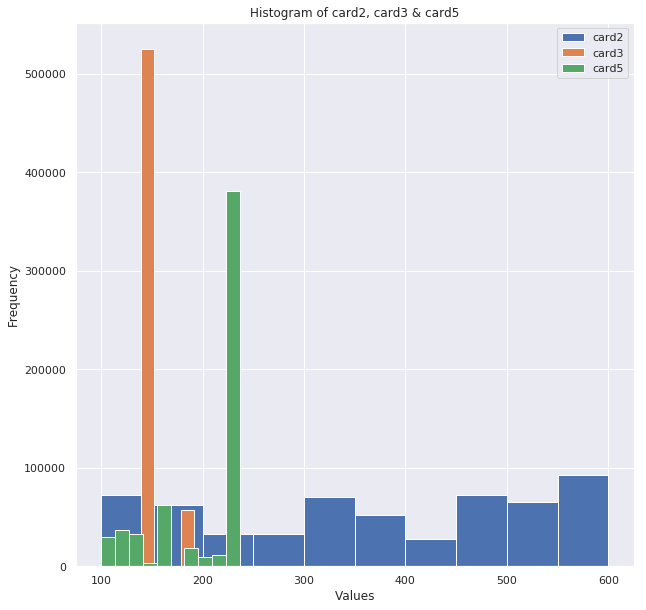

In [5]:


cards=['card1','card2','card3','card4','card5','card6']
# int, float, float, obj, float, obj


plt.figure(figsize=(10, 10))
plt.hist(train['card2'],label='card2')
plt.hist(train['card3'],label='card3')
plt.hist(train['card5'],label='card5')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of card2, card3 & card5')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Histogram of card4 column')

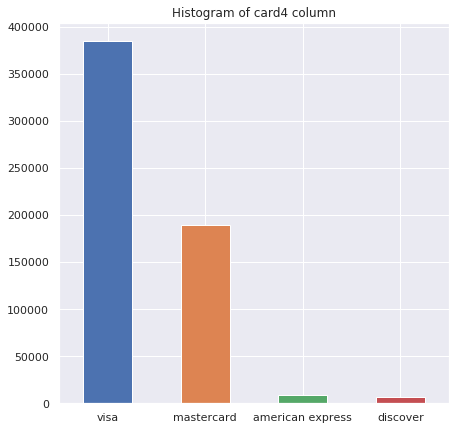

In [6]:
plt.figure(figsize=(7,7))
train['card4'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of card4 column')

Text(0.5, 1.0, 'Histogram of card6 column')

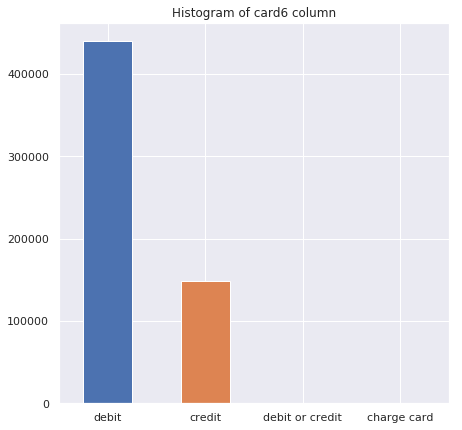

In [7]:
plt.figure(figsize=(7,7))
train['card6'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of card6 column')

Text(0.5, 1.0, 'Histogram of ProductCD column')

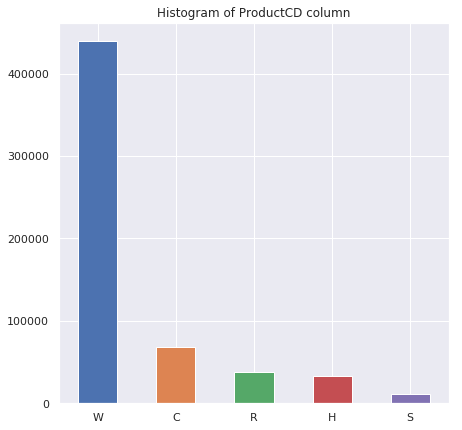

In [8]:
plt.figure(figsize=(7,7))
train['ProductCD'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of ProductCD column')

In [9]:
print(train['TransactionAmt'].describe())
print(train['TransactionAmt'].value_counts(dropna=False).head())

count    590540.000000
mean        135.027176
std         239.162522
min           0.251000
25%          43.321000
50%          68.769000
75%         125.000000
max       31937.391000
Name: TransactionAmt, dtype: float64
59.00     30582
117.00    28933
107.95    23954
57.95     23600
100.00    20362
Name: TransactionAmt, dtype: int64


In [10]:
C_s=['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14'] # All float type
D_s=['D1','D2', 'D3', 'D4', 'D10', 'D11', 'D15'] #All float type
M_s=['M1', 'M2', 'M3', 'M4', 'M6'] # All object type

In [11]:
for Cs in C_s:
    print('---------ABOUT {}--------'.format(Cs))
    print(train[Cs].describe())

---------ABOUT C1--------
count    590540.000000
mean         14.092458
std         133.569018
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        4685.000000
Name: C1, dtype: float64
---------ABOUT C2--------
count    590540.000000
mean         15.269734
std         154.668899
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        5691.000000
Name: C2, dtype: float64
---------ABOUT C3--------
count    590540.000000
mean          0.005644
std           0.150536
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          26.000000
Name: C3, dtype: float64
---------ABOUT C4--------
count    590540.000000
mean          4.092185
std          68.848459
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2253.000000
Name: C4, dtype: float64
---------ABOUT C5--------
count    590540.000000
mean       

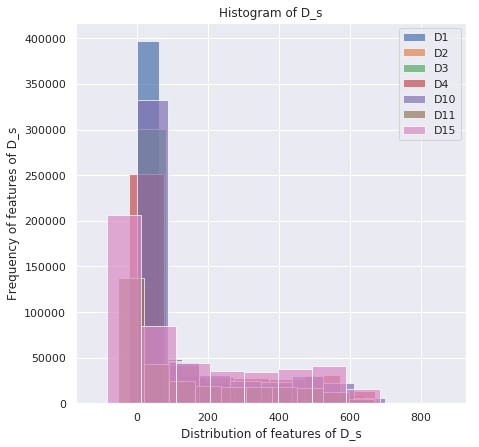

In [12]:
# for Ds in D_s:
#     print('---------ABOUT {}--------'.format(Ds))
#     print(train[Ds].describe())

plt.figure(figsize=(7,7))
for fig in D_s:
    plt.hist(train[fig],label=fig,alpha=0.7)
    plt.xlabel('Distribution of features of D_s')
    plt.ylabel('Frequency of features of D_s')
    plt.title('Histogram of D_s')
    plt.legend()

Text(0.5, 1.0, 'Histogram of M1 column/feature')

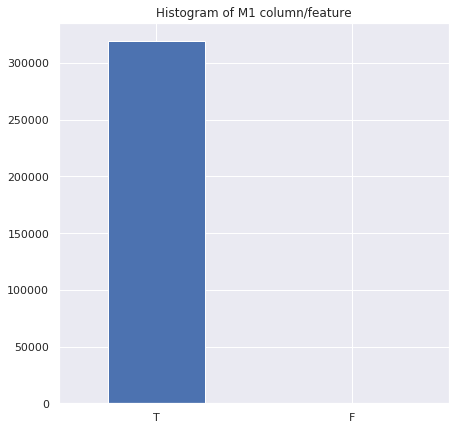

In [13]:
plt.figure(figsize=(7,7))
train['M1'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of M1 column/feature')

Text(0.5, 1.0, 'Histogram of M2 column/feature')

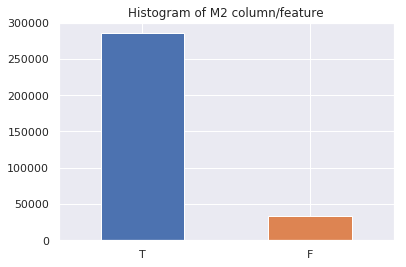

In [14]:
train['M2'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of M2 column/feature')

Text(0.5, 1.0, 'Histogram of M3 column/feature')

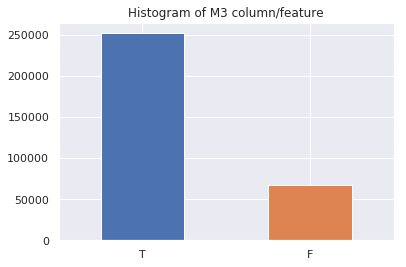

In [15]:
train['M3'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of M3 column/feature')

Text(0.5, 1.0, 'Histogram of M4 column/feature')

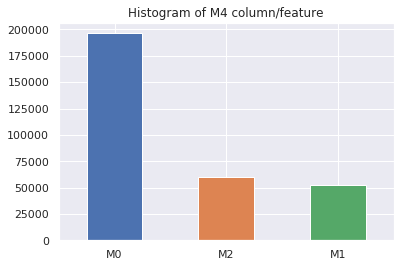

In [16]:
train['M4'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of M4 column/feature')

Text(0.5, 1.0, 'Histogram of M6 column/feature')

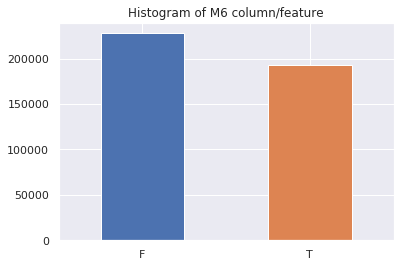

In [17]:
train['M6'].value_counts().plot(kind='bar',rot=0)
plt.title('Histogram of M6 column/feature')

In [18]:
# Finding data type of features from V1-V321 features
V_s=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
       'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37',
       'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46',
       'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55',
       'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64',
       'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73',
       'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82',
       'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91',
       'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100',
       'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108',
       'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116',
       'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124',
       'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132',
       'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281',
       'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289',
       'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297',
       'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305',
       'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313',
       'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']
Vs_type=set()
for item in V_s:
    Vs_type.add(train[item].dtype)

Vs_type

{dtype('float64')}

float64
count    524834.000000
mean        290.733794
std         101.741072
min         100.000000
25%         204.000000
50%         299.000000
75%         330.000000
max         540.000000
Name: addr1, dtype: float64
float64
count    524834.000000
mean         86.800630
std           2.690623
min          10.000000
25%          87.000000
50%          87.000000
75%          87.000000
max         102.000000
Name: addr2, dtype: float64
object
count        496084
unique           59
top       gmail.com
freq         228355
Name: P_emaildomain, dtype: object


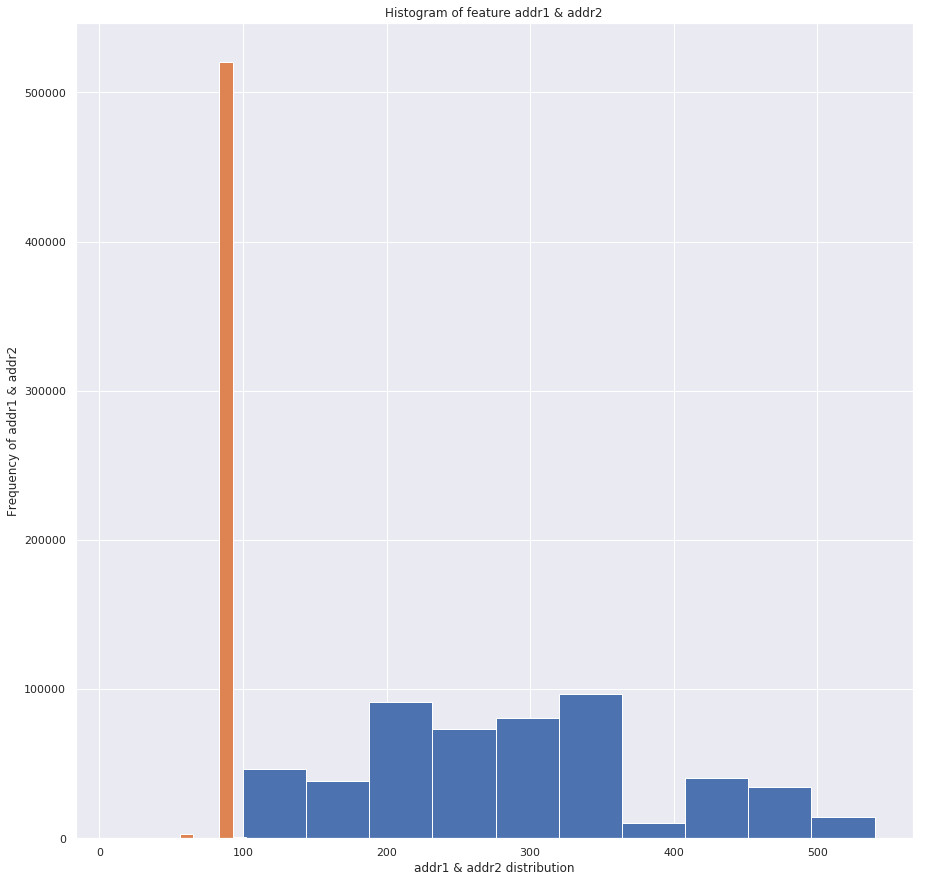

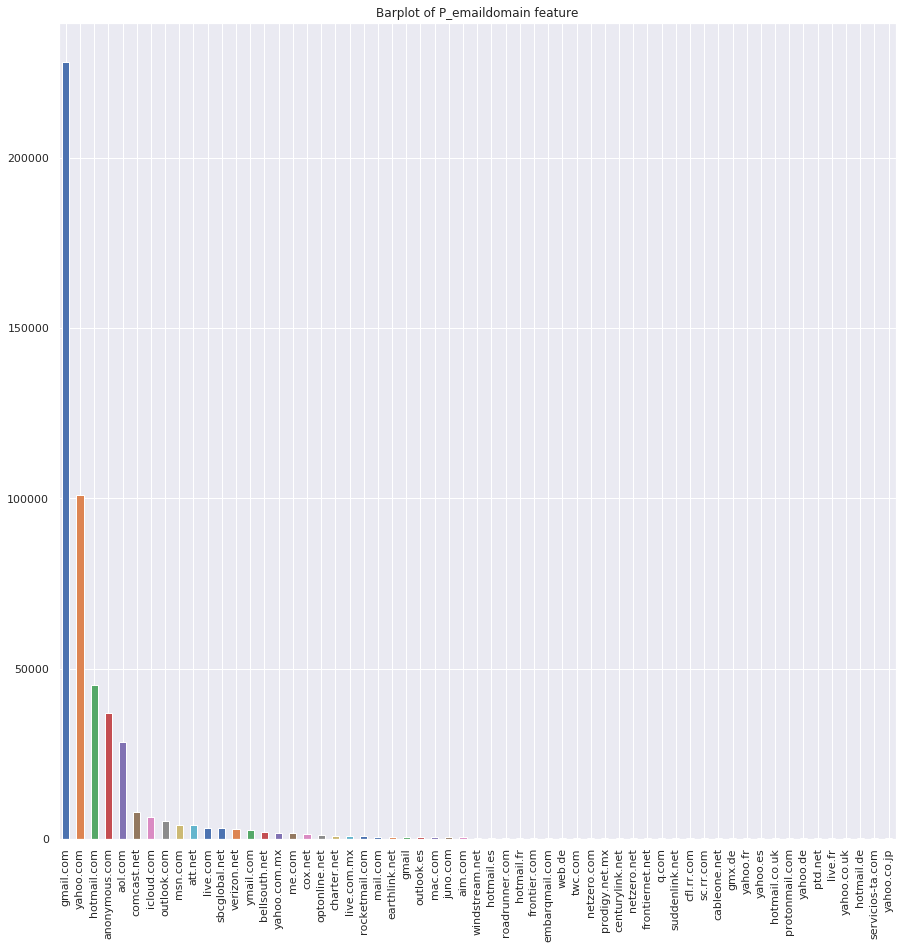

In [19]:
address=['addr1', 'addr2', 'P_emaildomain']
for item in address:
    print(train[item].dtype)
    print(train[item].describe())
    
plt.figure(figsize=(15,15))
plt.hist(train['addr1'],label='addr1')
plt.hist(train['addr2'],label='addr2')
plt.xlabel('addr1 & addr2 distribution')
plt.ylabel('Frequency of addr1 & addr2')
plt.title('Histogram of feature addr1 & addr2')
plt.show()

plt.figure(figsize=(15,15))
train['P_emaildomain'].value_counts().plot(kind='bar')
plt.title('Barplot of P_emaildomain feature')
plt.show()

# **Label Encoding**

In [20]:
for col in tqdm_notebook(train.columns):
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

# **Preparing Train & Test Data**

In [21]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [22]:
del test_id, test_tr, train_id, train_tr
X.shape, test.shape

((590540, 217), (506691, 431))

In [23]:
# Storing the names of features which still has NaN values
nan_col_train=list()
for ind in X.columns:
#     print(train[ind].value_counts(dropna=False, normalize=True).head())
    if X[ind].isna().any() == True:
        nan_col_train.append(ind)

# **LightGBM Hyperparameter Tuning**

In [24]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }

# **Preprocessing Test dataset** <br>
Renaming some test dataset features to match with train dataset and dropping features/columns from test dataset which is not used for training.

In [25]:

column_to_rename=['id-01', 'id-02', 'id-03', 'id-04', 'id-05',
       'id-06', 'id-07', 'id-08', 'id-09', 'id-10', 'id-11', 'id-12',
       'id-13', 'id-14', 'id-15', 'id-16', 'id-17', 'id-18', 'id-19',
       'id-20', 'id-21', 'id-22', 'id-23', 'id-24', 'id-25', 'id-26',
       'id-27', 'id-28', 'id-29', 'id-30', 'id-31', 'id-32', 'id-33',
       'id-34', 'id-35', 'id-36', 'id-37', 'id-38']
for item in column_to_rename:
    new_col=item.split('-')
    first=new_col[0]
    second=new_col[1]
    test.rename(columns={first+"-"+second:first+"_"+second},inplace=True)
    
test.drop(column_dropped,inplace=True,axis=1)


In [26]:
# Storing test dataset features which has NaN values
nan_col_test=list()
for ind in test.columns:
    if test[ind].isna().any()==True:
        nan_col_test.append(ind)

In [27]:
# No need to fill NaN as LightGBM can take NaN as input
print("{} columns have NaN or null in train set".format(len(nan_col_train)))
print("{} columns have NaN or null in test set".format(len(nan_col_test)))

192 columns have NaN or null in train set
163 columns have NaN or null in test set


# **Cross Validation by TimeSeriesSplit**

In [28]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    print(feature_importances.head())
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.998639	valid_1's auc: 0.897517
Early stopping, best iteration is:
[814]	training's auc: 0.997238	valid_1's auc: 0.897915
          feature  fold_1
0  TransactionAmt   22390
1       ProductCD    1273
2           card1   27997
3           card2   21710
4           card3     685
Fold 1 finished in 0:01:53.223928
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.996976	valid_1's auc: 0.919536
Early stopping, best iteration is:
[789]	training's auc: 0.994867	valid_1's auc: 0.920423
          feature  fold_1  fold_2
0  TransactionAmt   22390   27445
1       ProductCD    1273    1847
2           card1   27997   35146
3           card2   21710   31085
4           card3     685    1233
Fold 2 finished in 0:03:41.953668
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.994234	va

# **Plotting Important Features**

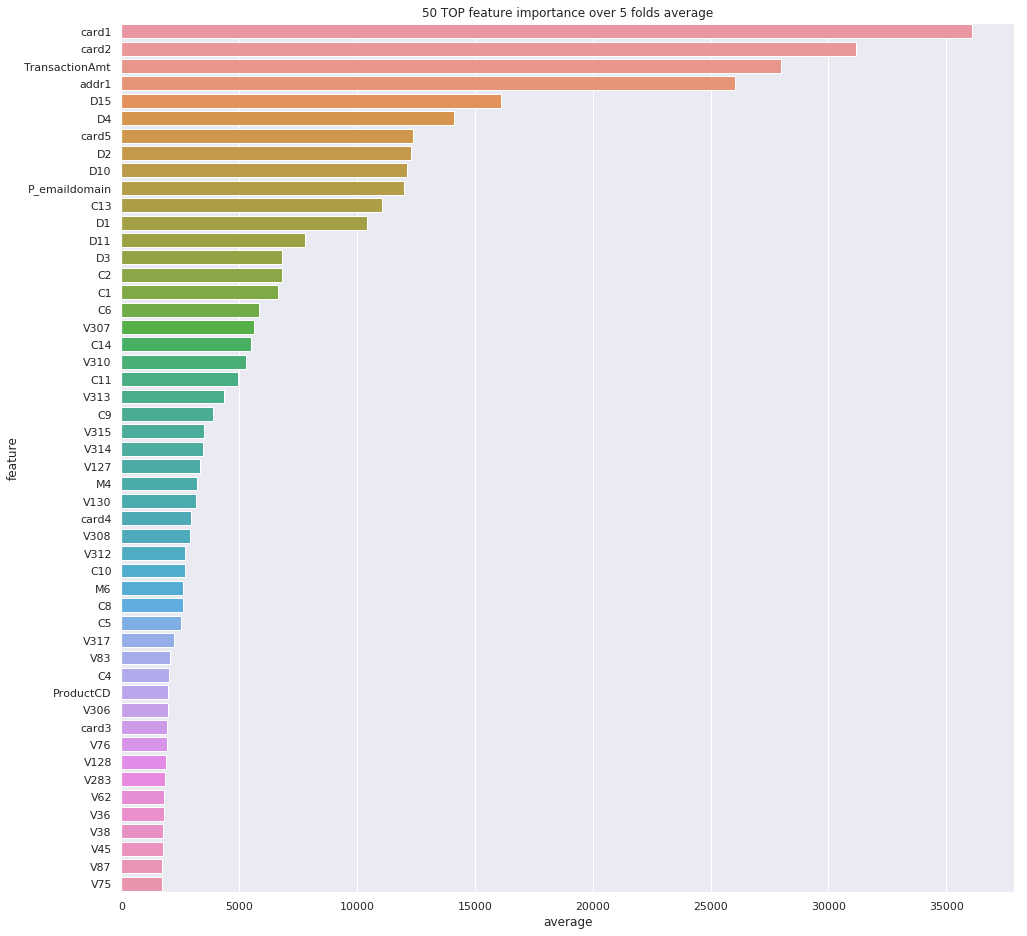

In [29]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

# **Training LightGBM**

In [30]:
# clf right now is the last model, trained with 80% of data and validated with 20%
best_iter = clf.best_iteration

clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=1324, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

# **Generating Submission File**

In [31]:
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('my_submission.csv', index=False)